# Visualize metapath performance against permutation

In [1]:
library(dplyr, warn = FALSE)

In [2]:
auroc_df = readr::read_tsv('data/auroc.tsv') %>%
  dplyr::mutate(fdr_significant = fdr_pval_auroc <= 0.05) %>%
  dplyr::filter(feature_type == 'DWPC') %>%
  dplyr::rename(metapath = feature)
head(auroc_df, 2)

,feature_type,metapath,nonzero,auroc,auroc_permuted,delta_auroc,pval_auroc,fdr_pval_auroc,fdr_significant
1,DWPC,CbG<rG<rGaD,0.62464,0.78515,0.6887,0.096447,0.0017381,0.015367,TRUE
2,DWPC,CbG<rG<rGdD,0.2506,0.66398,0.62906,0.034919,0.008788,0.034673,TRUE


In [3]:
auroc_df %>% dplyr::arrange(desc(pval_auroc)) %>% head(10)

,feature_type,metapath,nonzero,auroc,auroc_permuted,delta_auroc,pval_auroc,fdr_pval_auroc,fdr_significant
1,DWPC,CbGiGuDrD,0.45987,0.58351,0.5835,1.0032e-05,0.99929,0.99929,FALSE
2,DWPC,CdGr>G<rGuD,0.19947,0.65848,0.65847,6.5238e-06,0.99905,0.99929,FALSE
3,DWPC,CdGcGdDrD,0.2045,0.60523,0.60521,1.9572e-05,0.99753,0.99915,FALSE
4,DWPC,CtDaGbCtD,0.21351,0.77056,0.77061,-4.5283e-05,0.98997,0.99239,FALSE
5,DWPC,CbGcGuCpD,0.055099,0.52621,0.52613,8.4371e-05,0.98736,0.99058,FALSE
6,DWPC,CuGdAeGaD,0.49563,0.73148,0.73152,-3.7224e-05,0.98593,0.98996,FALSE
7,DWPC,CbGdDpCtD,0.11338,0.62615,0.62609,6.014e-05,0.98491,0.98974,FALSE
8,DWPC,CpDtCtD,0.023841,0.53231,0.53238,-7.6861e-05,0.98316,0.98879,FALSE
9,DWPC,CbGbCuGuD,0.29272,0.66569,0.66557,0.00012225,0.98046,0.98688,FALSE
10,DWPC,CdG<rGuD,0.18623,0.64546,0.64531,0.00014698,0.97975,0.98688,FALSE


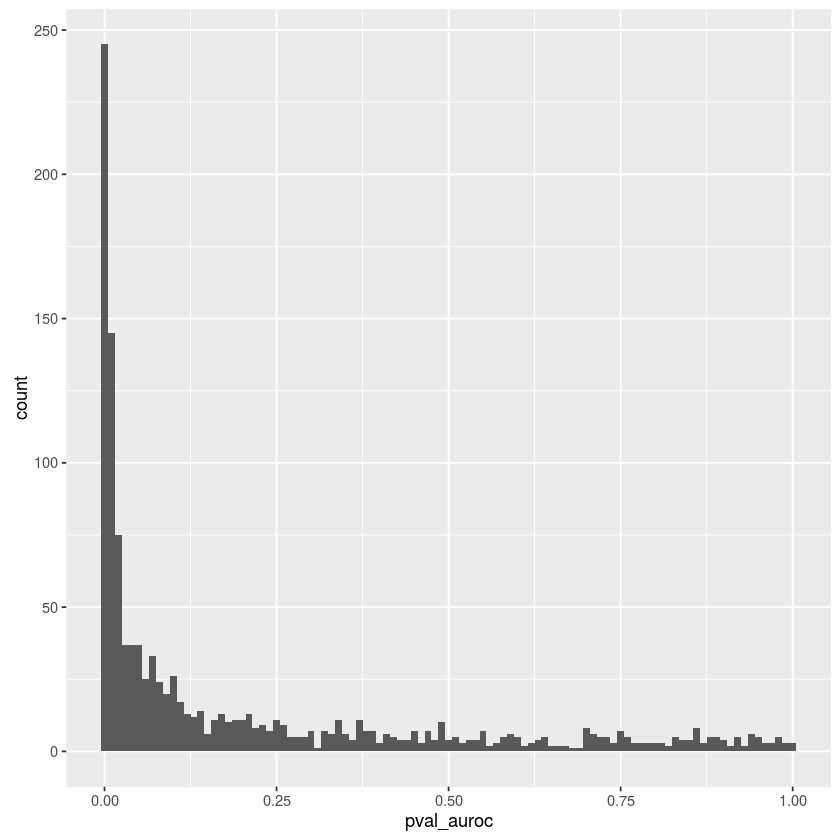

In [4]:
auroc_df %>%
  ggplot2::ggplot(ggplot2::aes(x = pval_auroc)) +
  ggplot2::geom_histogram(binwidth = 0.01)

In [5]:
metapath_df = 'data/metapaths.tsv' %>%
  readr::read_tsv()  %>%
  dplyr::transmute(metapath = abbreviation, length)

metaedge_df = readr::read_tsv('data/metaedge-in-metapath.tsv') %>%
  dplyr::inner_join(auroc_df) %>%
  dplyr::inner_join(metapath_df)

head(metaedge_df, 2)

Joining by: "metapath"
Joining by: "metapath"


,metapath,metaedge,metaedge_abbrev,feature_type,nonzero,auroc,auroc_permuted,delta_auroc,pval_auroc,fdr_pval_auroc,fdr_significant,length
1,CbGaD,Compound - binds - Gene,CbG,DWPC,0.23311,0.75173,0.64228,0.10944,8.416e-06,0.001514,TRUE,2
2,CbGaD,Disease - associates - Gene,DaG,DWPC,0.23311,0.75173,0.64228,0.10944,8.416e-06,0.001514,TRUE,2


In [6]:
metaedge_summary_df = metaedge_df %>%
  dplyr::group_by(metaedge) %>%
  dplyr::summarize(
    max_auroc = max(auroc),
    max_delta_auroc = max(delta_auroc)
  ) %>%
  dplyr::arrange(max_delta_auroc)

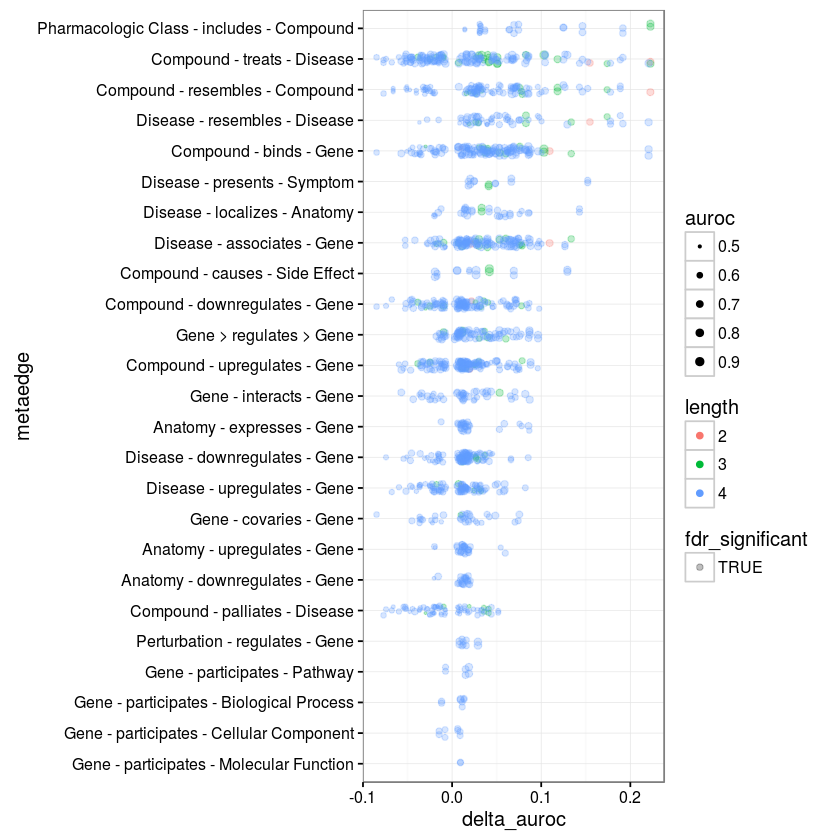

In [7]:
metaedge_df %>%
  dplyr::filter(fdr_significant) %>%
  dplyr::mutate(length = as.character(length)) %>%
  ggplot2::ggplot(mapping = ggplot2::aes(x = delta_auroc, y = metaedge)) +
  ggplot2::geom_jitter(mapping = ggplot2::aes(alpha = fdr_significant, color = length, size=auroc), height=0.4) +
  ggplot2::scale_y_discrete(limits = metaedge_summary_df$metaedge) +
  ggplot2::scale_alpha_manual(values=c('TRUE' = 0.25, 'FALSE' = 0.05)) +
  ggplot2::scale_size_continuous(range = c(0.5, 2)) +
  ggplot2::theme_bw()

In [8]:
mean(p.adjust(p = auroc_df$pval_auroc, method = 'bonferroni') < 0.05)

[1] 0.01069959

In [9]:
mean(p.adjust(p = auroc_df$pval_auroc, method = 'fdr') < 0.05)

[1] 0.3300412

In [10]:
mean(auroc_df$pval_auroc < 0.05)

[1] 0.4584362